In [11]:
import os
from dotenv import load_dotenv

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv()

# 환경 변수에서 OpenAI API 키를 가져옵니다.
openai_api_key = os.getenv("OPENAI_API_KEY")

# API 키가 존재하지 않는 경우 에러를 발생시킵니다.
if not openai_api_key:
    # API 키가 없다는 에러 메시지를 출력하고 프로그램을 종료합니다.
    raise ValueError("OpenAI API 키가 없습니다. 한 번 더 확인 부탁드립니다.")

In [16]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


@tool
def recommend_recipe(dish:str):
    """ 주어진 요리에 대한 간단한 레시피를 제공합니다"""
    recipes = {
        "파스타": "재료: 스파게티 면, 토마토 소스, 올리브 오일, 마늘. 면을 삶고 소스를 부어주세요.",
        "불고기": "재료: 소고기, 간장, 설탕, 마늘. 고기를 양념에 재워 볶아주세요.",
        "샐러드": "재료: 양상추, 토마토, 오이, 드레싱. 채소를 썰어 드레싱과 버무려주세요."
    }
    return recipes.get(dish, "죄송하지만 해당 요리의 레시피를 찾을 수 없습니다")

tools = [recommend_recipe]

tool_node = ToolNode(tools)

In [19]:
# 모델을 GPT로 변경
model = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

# 계속할지 여부를 결정하는 함수 정의
def should_continue(state: MessagesState):
    messages = state['messages']
    last_message = messages[-1]
    # LLM이 도구 호출을 하면 "tools" 노드로 라우팅
    if last_message.tool_calls:
        return "tools"
    # 그렇지 않으면 중지(사용자에게 응답)
    return END


# 모델을 호출하는 함수 정의
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # 기존 목록에 추가되기 때문에 목록을 반환합니다.
    return {"messages": [response]}


# 새로운 그래프 정의
workflow = StateGraph(MessagesState)

# 사이클링할 두 노드 정의
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 진입점을 `agent`로 설정
# 이는 첫 번째로 호출되는 노드를 의미합니다.
workflow.set_entry_point("agent")

# 조건부 경로 추가
workflow.add_conditional_edges(
    # 먼저, 시작 노드를 정의합니다. `agent`를 사용합니다.
    # 이는 `agent` 노드가 호출된 후의 경로를 의미합니다.
    "agent",
    # 다음으로, 어느 노드가 다음에 호출될지 결정하는 함수를 전달합니다.
    should_continue,
)

# `tools`에서 `agent`로의 일반 경로 추가
# 이는 `tools`가 호출된 후 `agent` 노드가 다음에 호출된다는 것을 의미합니다.
workflow.add_edge("tools", 'agent')

In [20]:
# 그래프 실행 간 상태를 유지하기 위해 메모리 초기화
checkpointer = MemorySaver()

# 마지막으로 컴파일합니다!
# 이를 LangChain Runnable로 컴파일하여,
# 다른 runnable처럼 사용할 수 있게 합니다.
# 그래프를 컴파일할 때 메모리를 옵션 checkpointer로 전달할수 있습니다.
app = workflow.compile(checkpointer=checkpointer)

In [21]:
# 에이전트와의 상호작용
final_state = app.invoke(
    {"messages": [HumanMessage(content="불고기 레시피 알려줄래?")]},
    config={"configurable": {"thread_id": 100}}
)
final_state["messages"][-1].content

'불고기 레시피는 다음과 같습니다:\n\n### 재료\n- 소고기\n- 간장\n- 설탕\n- 마늘\n\n### 조리 방법\n1. 소고기를 얇게 썰어주세요.\n2. 간장, 설탕, 다진 마늘을 섞어 양념을 만듭니다.\n3. 썰어놓은 소고기를 양념에 재워 30분 정도 둡니다.\n4. 팬에 기름을 두르고 재운 소고기를 볶아주세요.\n5. 고기가 익으면 접시에 담아 맛있게 즐기세요!\n\n맛있게 만들어 드세요!'

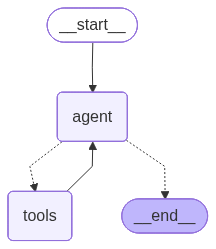

In [22]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [23]:
# 동일한 "thread_id"를 사용하여 Runnable을 다시 호출
final_state = app.invoke(
    {"messages": [HumanMessage(content="방금 어떤 레시피를 알려주었지?")]},
    config={"configurable": {"thread_id": 100}}
)
final_state["messages"][-1].content

'방금 불고기 레시피를 알려드렸습니다. 소고기를 간장, 설탕, 마늘로 양념하여 볶는 간단한 요리 방법이었습니다.'